In [46]:
# so kernel doesn't have to be restarted
%load_ext autoreload
%autoreload 2

# sklearn imports
from sklearn.neighbors import NearestNeighbors, KNeighborsTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# data science imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# imodels imports
from imodels import get_clean_dataset
from imodels.tree.rf_plus.rf_plus.rf_plus_models import RandomForestPlusClassifier
from imodels.tree.rf_plus.feature_importance.rfplus_explainer import RFPlusMDI

# data getters
from ucimlrepo import fetch_ucirepo
import openml

# local feature importance
import shap
import lime

# helper scripts
from knn_helper import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
# set seed
np.random.seed(42)

# get and split data
# X, y = get_data('uci', 15)
X, y, = get_data('openml', 43)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.33, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

/accounts/grad/zachrewolinski/research/imodels-experiments/feature_importance/counterfactuals/knn_helper.py:68: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = openml.datasets.get_dataset(data_id)


In [48]:
# get fit models
rf, rf_plus = fit_models(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished


In [49]:
# get shap
shap_valid = get_shap(X_valid, rf)
shap_test = get_shap(X_test, rf)

# get lime
lime_valid = get_lime(X_valid, rf)
lime_test = get_lime(X_test, rf)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
# get lmdi values
lmdi_valid = get_lmdi(X_valid, y_valid, rf_plus)
lmdi_test = get_lmdi(X_test, y_test, rf_plus)

In [ ]:
# fit nearest neighbor models
shap_nbrs = NearestNeighbors(n_neighbors=len(X_valid))
shap_nbrs.fit(shap_valid)
lime_nbrs = NearestNeighbors(n_neighbors=len(X_valid))
lime_nbrs.fit(lime_valid)
lmdi_nbrs = NearestNeighbors(n_neighbors=len(X_valid))
lmdi_nbrs.fit(lmdi_valid)

# get distances and indices of neighbors, ranked
shap_dist, shap_idxs = shap_nbrs.kneighbors(shap_test)
lime_dist, lime_idxs = lime_nbrs.kneighbors(lime_test)
lmdi_dist, lmdi_idxs = lmdi_nbrs.kneighbors(lmdi_test)

In [ ]:
k = 3
shap_opposite = get_k_opposite_neighbors(k, shap_valid, shap_test, y_valid, y_test)
lime_opposite = get_k_opposite_neighbors(k, lime_valid, lime_test, y_valid, y_test)
lmdi_opposite = get_k_opposite_neighbors(k, lmdi_valid, lmdi_test, y_valid, y_test)

In [ ]:
shap_distances = get_average_nbr_dist(k, shap_opposite, X_valid, X_test)
lime_distances = get_average_nbr_dist(k, lime_opposite, X_valid, X_test)
lmdi_distances = get_average_nbr_dist(k, lmdi_opposite, X_valid, X_test)

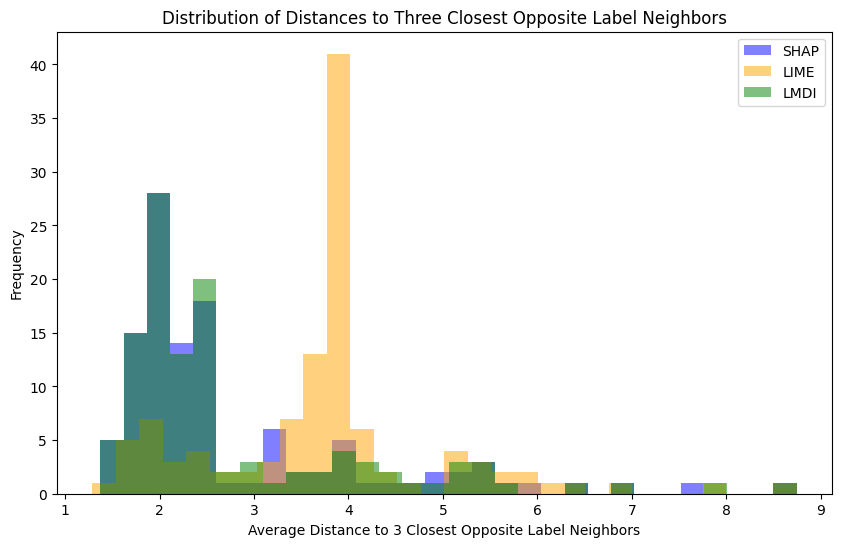

In [ ]:
# plot distances
plt.figure(figsize=(10, 6))
plt.hist(shap_distances, bins=30, alpha=0.5, label='SHAP', color='blue')
plt.hist(lime_distances, bins=30, alpha=0.5, label='LIME', color='orange')
plt.hist(lmdi_distances, bins=30, alpha=0.5, label='LMDI', color='green')
plt.xlabel('Average Distance to 3 Closest Opposite Label Neighbors')
plt.ylabel('Frequency')
plt.title('Distribution of Distances to Three Closest Opposite Label Neighbors')
plt.legend()
plt.show()